# vPCF Shifts Simulation
We've seen apparent shifting of $c$-planes relative to one another in vPCFs of wurtzites. One theory is that this may be due to the intensity of the nitrogen columns "pulling" the apparent center of the metal columns off to the sides (when fitted with gaussians). This notebook will test that.

In [1]:
from pathlib import Path
from utils import tk_popover

import abtem
import numpy as np
import ase.io as aio
from ase.build import surface
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sim_stem import simulate_stem, preview_stem_result

import SingleOrigin as so

# Simulation

In [3]:
# Setup abTEM / Dask parameters
abtem.config.set({"device":              "cpu",  # Configure abTEM to run on the GPU
                  "dask.lazy":           True,  # Setting to False can be useful for debugging
                  "dask.chunk-size":     "128 MB",  # 128 MB is the standard L3 cache size (per core)
                  "dask.chunk-size-gpu": "512 MB",  # Remember to leave space for overhead
                  "scheduler":           "threads",  # Threads or processes
                  "num_workers":         32  # Number of threads/processes to use for simulation (set to 1 for gpu)
                  })

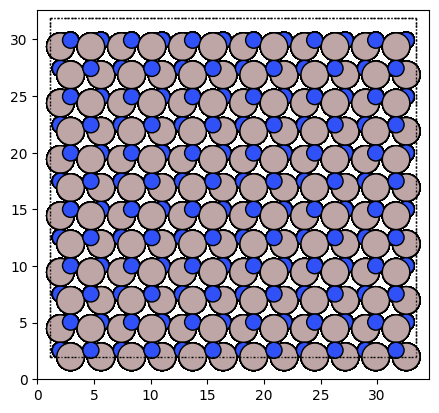

In [7]:
%matplotlib inline

# Open .cif & generate the potential
thickness: float = 200  # Angstrom; total thickness (z direction)
reps: int = 6  # How many repeats to have in x and y directions

cifpath = Path(tk_popover())  # Open AlN .cif file
uc = aio.read(cifpath)

# Get spanning vectors for the projected cell
# We do this with a temporary structure so we can set layers=1
c = np.linalg.norm(surface(uc, indices=(1, 1, 0), layers=1, periodic=True).cell[2])

surf = surface(uc, indices=(1, 1, 0), layers=int(thickness//c + 1), periodic=True)
slab = abtem.orthogonalize_cell(surf)
slab *= (reps, reps, 1)
plot_atoms(slab)

# Creating the potential takes couple minutes
potential = abtem.Potential(slab,
                            sampling=0.04,
                            projection="infinite",
                            parametrization="kirkland",
                            slice_thickness=2)
detector = abtem.detectors.AnnularDetector(46, 200)

In [60]:
# Probe aberrations (based on Themis), up to 5th order; units are Angstrom & radian
aberrations = {"C10":   22,     # Defocus (C1)
               "C12":   7,      # 2-fold stig (A1)
               "phi12": 2.71,   # 2-fold stig angle
               "C21":   335,    # Coma (B2)
               "phi21": 2.67,   # Coma angle
               "C23":   480,    # 3-fold stig (A2)
               "phi23": 0,      # 3-fold stig angle
               "C30":   -5200,  # Spherical aber (C3 / CS)
               "C32":   7600,   # "Star" aber (S3)
               "phi32": -0.37,  # Star aber angle
               "C34":   3900,   # 4-fold stig (A3)
               "phi34": -1.71,  # 4-fold stig angle
               "C41":   8.4e4,  # 4th order coma (B4)
               "phi41": -0.24,  # 4th order coma angle
               "C43":   1.4e5,  # Three-lobe aber (D4)
               "phi43": 1.40,   # Three-lobe aber angle
               "C45":   1.1e4,  # 5-fold stig (A4)
               "phi45": 1.40,   # 5-fold stig angle
               "C50":   -8e6,   # 5th order spherical aber (C5)
               "C52":   9.7e5,  # 5th order star aber (S5)
               "phi52": 2.04,   # 5th order star aber angle
               "C54":   3.2e5,  # Rosette aber (R5)
               "phi54": -2.09,  # Rosette aber angle
               "C56":   2.8e6,  # 6-fold stig (A5)
               "phi56": 0.98    # 6-fold stig angle
               }

# View probe and verify profile before simulating
# Adding these aberrations has little effect on the FWHM, but changes the tails and reduces the max intensity slightly
%matplotlib Tk
abtem.Probe(semiangle_cutoff=17.9, energy=200e3, aberrations=aberrations).match_grid(potential).show()

[########################################] | 100% Completed | 206.11 ms


In [50]:
# Run the simulation
fpath = tk_popover(save=True)  # Setup filename before running the simulation, so we can save automatically
result = simulate_stem(potential=potential, detectors=detector, convergence=17.9, aberrations=aberrations, eager=True)

Simulating...
[########################################] | 100% Completed | 44m 39s


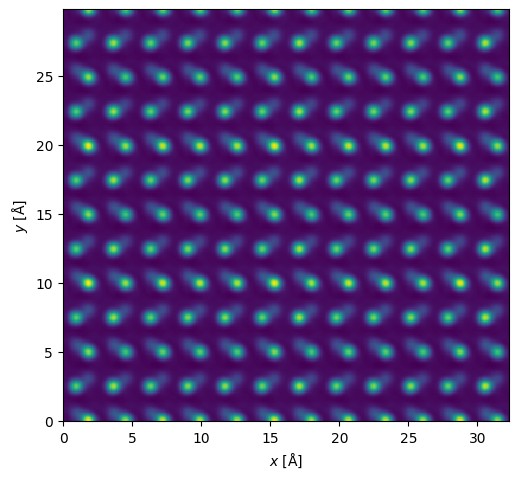

In [51]:
# Preview & save the result
preview_stem_result(result)
result.to_tiff(fpath)

# Fitting

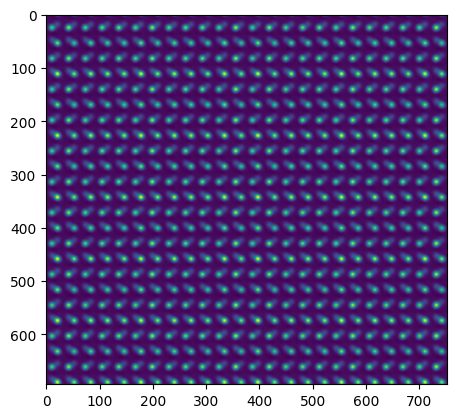

In [52]:
%matplotlib inline

loaded = np.flipud(so.load_image(tk_popover(), display_image=False)[0].T)  # Coordinate axes transposed by save/load
# FFT interpolation
factor: float = 4  # 4 is equivalent to what is seen in the above preview
pad_height, pad_width = (factor-1)*loaded.shape[0]//2, (factor-1)*loaded.shape[1]//2
# noinspection PyTypeChecker
padded_fft = np.pad(np.fft.fftshift(np.fft.fft2(loaded)), ((pad_height, pad_height), (pad_width, pad_width)))
interp = np.fft.ifft2(np.fft.ifftshift(padded_fft)).real
# Tile for larger FFT and more vPCF points later
tiled = np.tile(interp, (2, 2))
plt.imshow(tiled)

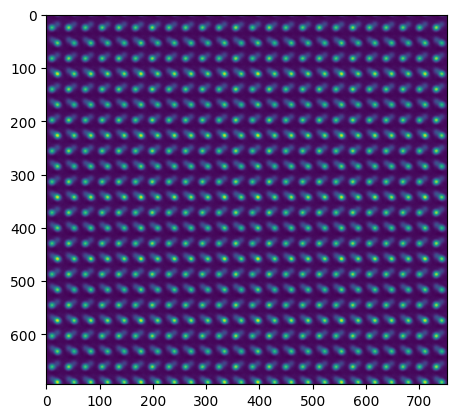

In [53]:
# Functions to add poisson noise
def add_poisson_noise(img: np.ndarray, px_size: float, dose: float) -> np.ndarray:
    valmin, valmax = np.min(img), np.max(img)
    normed = (img - valmin) / (valmax - valmin)
    e_per_px = dose * px_size**2
    return np.random.poisson(normed * e_per_px)

noisy = add_poisson_noise(tiled, 0.162, 1e5)
plt.imshow(noisy)

transformed lattice parameters: 
 a1:     3.111 
 a2:     5.3884 
 a3:     4.978 
 alpha:  90.0 
 beta:   90.0 
 gamma:  90.0 
Distances (in Angstroms) being combined...
None to combine


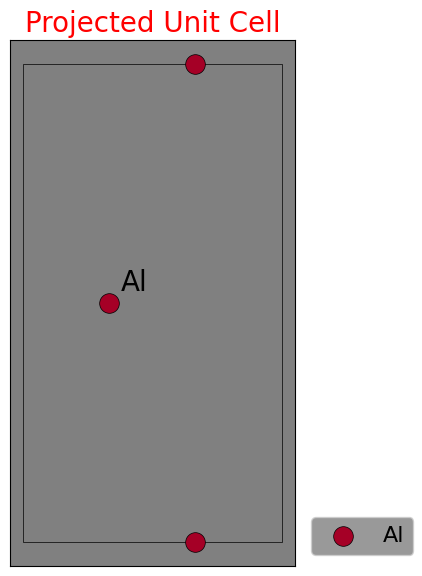

In [54]:
# SingleOrigin setup: UnitCell
uc_so = so.UnitCell(tk_popover())
uc_so.project_zone_axis((1, 1, 0),  # Zone axis direction
                     (1, -1, 0),  # Apparent horizontal axis in projection
                     (0, 0, 1),  # Most vertical axis in projection
                     ignore_elements=["N"],  # List of elements to ignore (e.g. light elements in a HAADF image)
                     reduce_proj_cell=True)
uc_so.combine_prox_cols(toler=1e-2)  # 1e-2 works well as a tolerance, but adjust as needed
uc_so.plot_unit_cell()

In [55]:
# SingleOrigin setup: HRImage & lattice
hr_img = so.HRImage(noisy)
lattice = hr_img.add_lattice("AlN", uc_so, origin_atom_column=None)
# Define reference lattice
%matplotlib tk
lattice.fft_get_basis_vect(a1_order=1, a2_order=2, thresh_factor=0.1)
lattice.define_reference_lattice()
%matplotlib inline

pick coordinates: [397.34 285.1 ] 
detected peak coordinates: [397, 285] 

Creating reference lattice...
Performing rough reference lattice refinement...


In [56]:
lattice.fit_atom_columns(buffer=1,
                         bkgd_thresh_factor=0,
                         use_bounds=True,
                         pos_bound_dist=1,
                         use_circ_gauss=False,
                         parallelize=True,
                         peak_grouping_filter=None,
                         peak_sharpening_filter="auto")

lattice.refine_reference_lattice(filter_by="elem", sites_to_use="Al")

Preparing to fit atom columns...
Step 1 (Initial checks): 0.01 sec
Step 2 (fitting masks): 0.75 sec
Step 3 (grouping masks) was skipped.
Step 4 (Final prep): 0.06 sec
Fitting atom columns...
Using parallel processing


  0%|          | 0/576 [00:00<?, ?it/s]C:\Users\charles\Documents\GitHub\venv_gh\Lib\site-packages\joblib\externals\loky\process_executor.py:1076: UserWarning: On Windows, max_workers cannot exceed 61 due to limitations of the operating system.
  warnings.warn(
100%|██████████| 576/576 [00:05<00:00, 107.04it/s]


Step 5 (Fitting): 5.53 sec
Step 6 (Post-processing): 0.02 sec 
 Done.
Origin shift: [-0.13123573 -0.2679881 ]
Optimized basis vectors: [[ 3.13291368e+01 -2.82919648e-03]
 [ 7.83593601e-03 -5.78277893e+01]]

Residual distortion of reference lattice basis vectors from .cif:
Scalar component: -0.1005 %
Shear component: 0.000226 (radians)
Estimated Pixel Size: 8.604 (pm)


0.08603998173585088


(<Figure size 1300x1000 with 1 Axes>,
 <Axes: title={'center': 'Warning: scalebar length is based on the pixel size estimated from the reference lattice. The user should specify the calibrated pixel size if known.'}>)

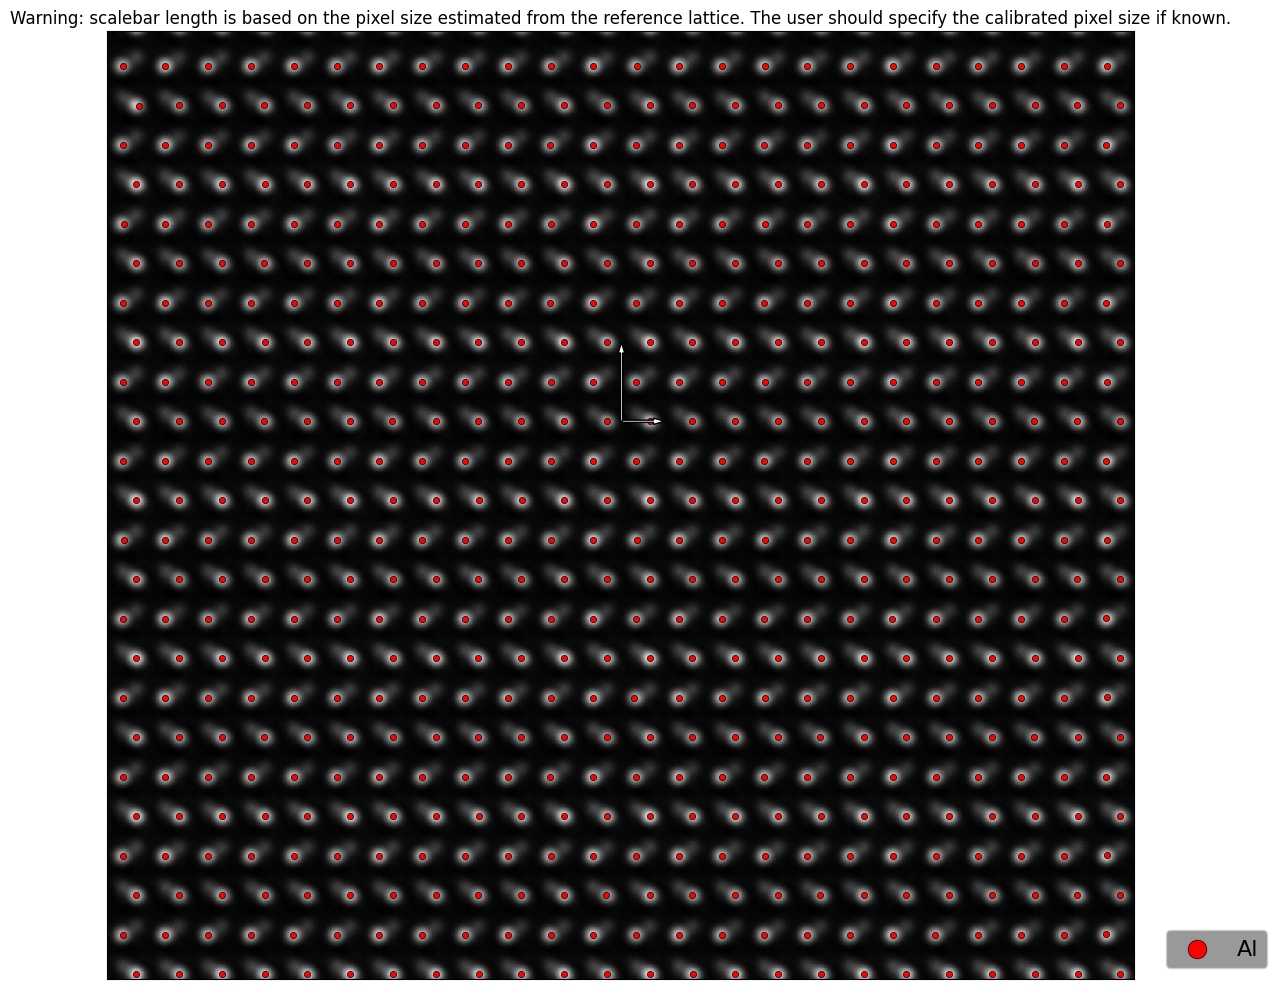

In [57]:
hr_img.plot_atom_column_positions(scatter_kwargs_dict={"s": 20}, scalebar_len_nm=None, fit_or_ref="fit")

Calculating Al-Al vPCF


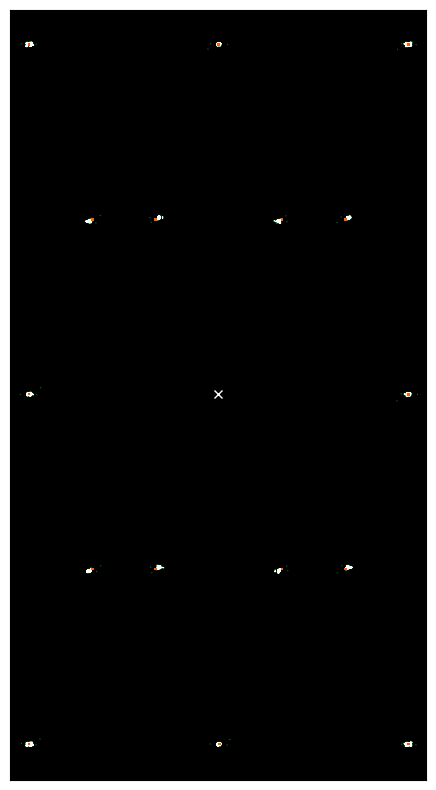

In [58]:
lattice.get_vpcfs(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1), d=0.01)
vpcf, origin = lattice.vpcfs["Al-Al"], lattice.vpcfs["metadata"]["origin"]

ref_coords = lattice.at_cols.loc[lattice.at_cols["elem"] == "Al", "x_ref":"y_ref"].to_numpy() * lattice.pixel_size_est
ref_xlimits, ref_ylimits = (-1.1*lattice.a_2d[0][0], 1.1*lattice.a_2d[0][0]), (-1.1*lattice.a_2d[1][1], 1.1*lattice.a_2d[1][1])
ref_vpcf = so.get_vpcf(coords1=ref_coords, xlim=ref_xlimits, ylim=ref_ylimits, d=0.01)[0]

# Plotting – need Tk window for rescaling on save
vpcf_fig, vpcf_ax = plt.subplots()
cmap = LinearSegmentedColormap.from_list("black-green-white", ["#000000FF", "#117733ff", "#ffffffff"], 256)
cmap_ref = LinearSegmentedColormap.from_list("transparent-orange", ["#00000000", "#fe6100ff"], 2)
vpcf_ax.imshow(vpcf, cmap=cmap, vmin=0, vmax=100, interpolation=None)
vpcf_ax.imshow(ref_vpcf, cmap=cmap_ref, vmin=0, vmax=1, interpolation=None)
vpcf_ax.plot(origin[0], origin[1], "wx")  # Plot the origin as an "x"
vpcf_ax.get_xaxis().set_visible(False)
vpcf_ax.get_yaxis().set_visible(False)

# DO NOT close the plot window first, or an error will be thrown
savedir = tk_popover(save=True, defaultextension=".png")
if savedir == Path("."):
    pass  # Don't save to ".", it usually means file dialog was canceled or closed
else:
    vpcf_fig.set_size_inches(10, 10)
    vpcf_fig.savefig(savedir, dpi=600, bbox_inches="tight")
%matplotlib inline

# Summary of Results
- **20nm, no aberrations**: no visible row shifting.
- **20nm, with aberrations**: apparent row shifting!

So, in the presence of a realistic probe shape, even fairly thin samples show this apparent row-to-row shift. It's an artifact!

Other things to explore for a more wholistic understanding could include:
- Varying aberrations
- Mistilt
- Partial spatial coherence
- Thickness
- Frozen phonons

But someone else can follow up on this (or maybe I'll have time after defending).

## Bonus
It appears that we may be able to measure polarity this way, even without well-resolved nitrogen columns! Here, the simulated images used to generate the vPCFs were "nitrogen-polar" (if we assume the "substrate" to be somewhere below the image). The next-row-neighbor shifts are down-left & up-right. However in experimental images from (Al,Gd)N we consistently see next-row-neighbor shifts up-left and down-right, which suggests metal polarity!

Of course, we'd need to study how sensitive this is to other effects (the ones in the above list) before being too confident. If those effects were well understood, though, and if they are not too significant, we might be able to measure not only polarity but polarization.